<a href="https://colab.research.google.com/github/RaduW/volume-rebalance/blob/main/rebalance_adjustment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Rebalance Adjustment

In [101]:
# url = "https://raw.githubusercontent.com/RaduW/volume-rebalance/main/transaction_adjustment_model.py"
# !wget --no-cache --backups=1 {url}
#
from transaction_adjustment_model import adjust_sample_rate_v2
#
# utils_url = "https://raw.githubusercontent.com/RaduW/volume-rebalance/main/utils.py"
# !wget --no-cache --backups=1 {utils_url}

import utils

In [102]:

from typing import Tuple, Union, List
from ipywidgets import widgets
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from pprint import pprint
sns.set_style("whitegrid")


In [103]:
# import transaction data
projects = "https://raw.githubusercontent.com/RaduW/volume-rebalance/main/projects-2023-03-30.json"
trans_data = pd.read_json(projects)

PROJECTS = {
    "sentry": 1,
    "javascript": 11276,
    "snuba": 300688,
    "gibpotato-backend": 4504044639748096,
    #"gibpotato-frontend": 4504044640927744,
}

# sort by project and frequency and re-index
trans_data.sort_values(by=["proj_id","freq"],ignore_index=True, ascending=True, inplace=True)
trans_data = trans_data.reset_index(drop=True)


# Model params

The model has the following input parameters:

*   a list of initial counts representing the number of elements for each class `counts`
*   an overall desired sample rate: `global_rate` (input via slider)



In [104]:
def process_data(counts:List[float], global_rate:float, items_high:int, items_low:int, intensities:List[float]):


    transactions = [(utils.idx_to_label(idx),count) for idx,count in enumerate(counts)]

    explicit_transactions =[*transactions[:items_low], *transactions[-items_high:]]

    frames = []
    for intensity in intensities:
        explicit,implicit= adjust_sample_rate_v2(explicit_transactions,rate=rate,total_num_classes=num_classes,total=total, intensity=intensity)
        freq = [x[1] for x in transactions]
        name = [x[0] for x in transactions]

        df = pd.DataFrame({"name":name, "freq":freq})
        df = df.set_index("name")
        adjusted_df = pd.DataFrame.from_dict(data = explicit, orient="index", columns=["adjusted_rate"] )
        df = df.join(adjusted_df, how="outer")
        df.sort_values(by="freq", inplace=True, ascending=False)
        # # keep count of the explicit rates
        df["explicit"]= ~df['adjusted_rate'].isna()
        # # set the adjusted rates for the implicit values
        df["adjusted_rate"] = df["adjusted_rate"].fillna(implicit)

        df["adjusted"] = df["freq"]* df["adjusted_rate"]
        df["intensity"] = intensity
        frames.append(df)

    return pd.concat(frames)

def plot_intensities(df):
    fig, ax = plt.subplots(nrows = 1 ,figsize=(9,9))
    sns.lineplot(data=df, x="freq", y="adjusted_rate",  ax=ax, hue="intensity" )
    sns.scatterplot(data=df, x="freq", y="adjusted_rate" , ax=ax, hue="intensity", legend=False);



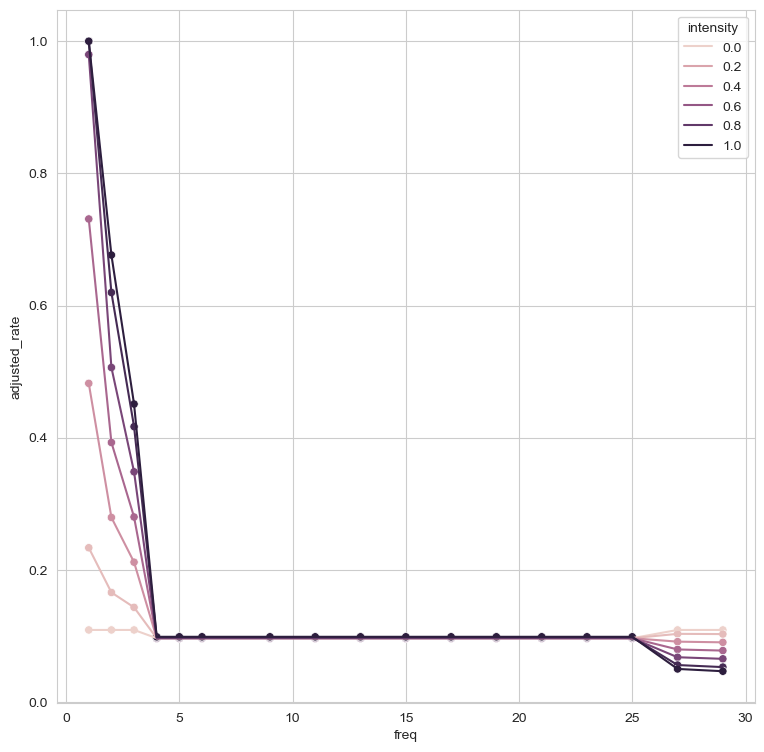

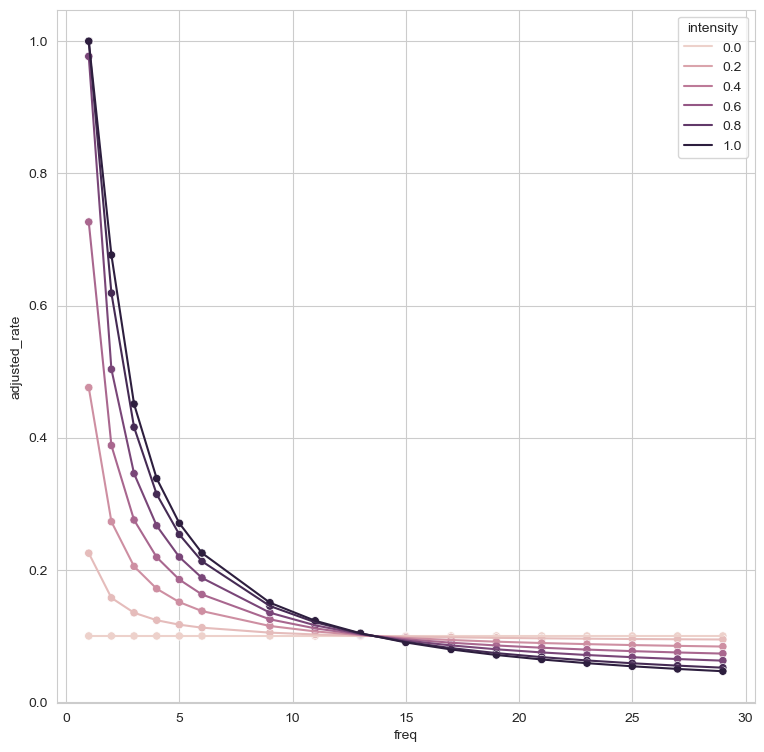

In [108]:
#data = [*range(1,7), *range(20,90,10), *range(1000,3001,1000)]
data = [*range(1,7), *range(9,30,2) ]

total = reduce(lambda x,y: x+y, data)
num_classes = len(data)
rate= 0.1
intensity=0.5
low=3
high=2
intensities = [0, 0.1, 0.3,  0.5,0.7,0.9,1.0]
df = process_data(counts=data, global_rate=rate,items_high=high,items_low=low, intensities=intensities)
plot_intensities(df);
df = process_data(counts=data, global_rate=rate,items_high=len(data),items_low=0, intensities=intensities)
plot_intensities(df)


# Scratch pad below

Ignore....
